In [1]:
print("""
@Title        : Time Series Analysis and Forecasting
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2023-12-24 00:39:34
@Description  : 
""")


@Title        : Time Series Analysis and Forecasting
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2023-12-24 00:39:34
@Description  : 



## Time series decomposition

In [10]:
import pandas as pd
import quandl
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
with open('../../token/quandl.txt', 'r') as f:
    token = f.read()
quandl.ApiConfig.api_key = token

In [3]:
df = (
    pd.read_csv('../data/UNRATENSA.csv', parse_dates=['DATE'], index_col='DATE')
    .rename_axis('Date', axis=0)
    .rename(columns={'UNRATENSA': 'unemp_rate'}))
df.sample(5)

,unemp_rate
Date,
2012-01-01,8.8
2017-06-01,4.5
2016-07-01,5.1
2018-04-01,3.7
2019-11-01,3.3


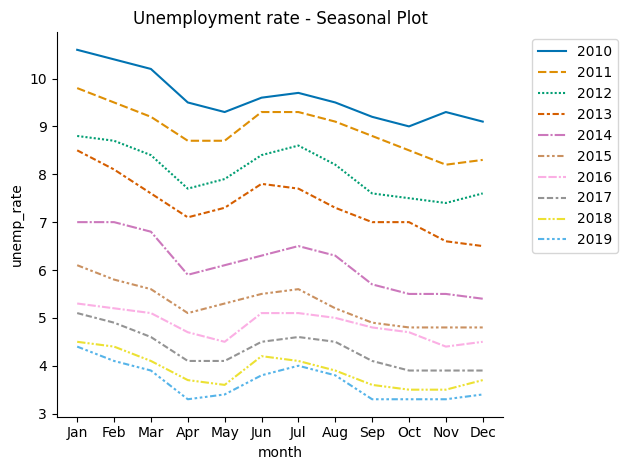

In [13]:
temp_df = df.copy()
temp_df['year'] = temp_df.index.year
temp_df['month'] = temp_df.index.strftime('%b')

sns.lineplot(data=temp_df,
             x='month',
             y='unemp_rate',
             hue='year',
             style='year',
             legend='full',
             palette='colorblind')
plt.title('Unemployment rate - Seasonal Plot')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.tight_layout()

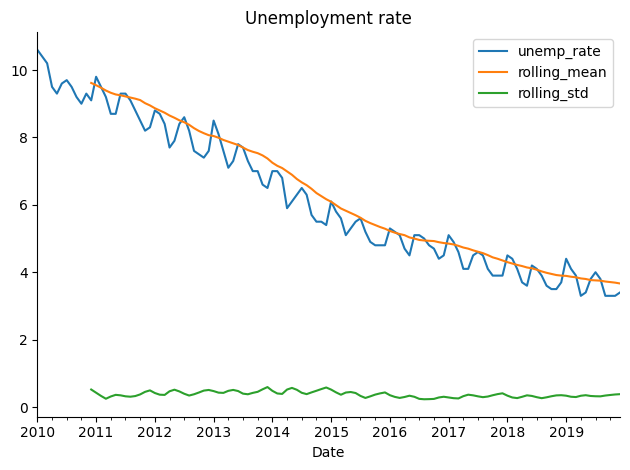

In [15]:
WINDOW_SIZE = 12
df['rolling_mean'] = df['unemp_rate'].rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df['unemp_rate'].rolling(window=WINDOW_SIZE).std()

df.plot(title='Unemployment rate')
sns.despine()
plt.tight_layout()

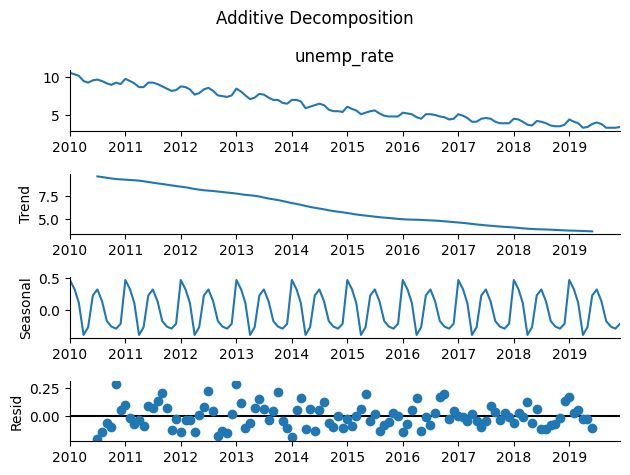

In [18]:
decomposition_results = seasonal_decompose(df['unemp_rate'],
                                           model='additive')
(
    decomposition_results
    .plot()
    .suptitle('Additive Decomposition')
)
sns.despine()
plt.tight_layout()

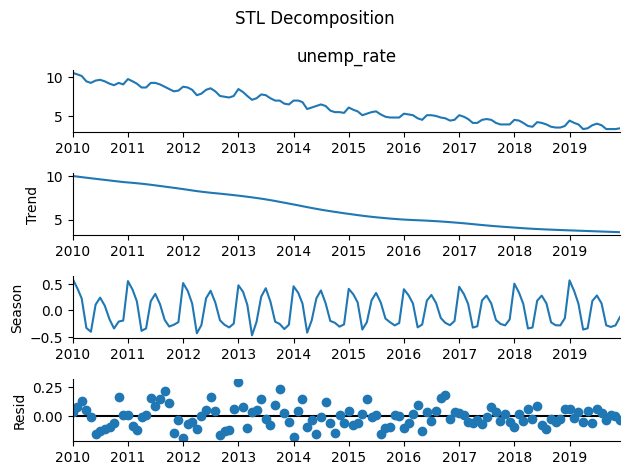

In [20]:
from statsmodels.tsa.seasonal import STL

stl_decomposition = STL(df['unemp_rate']).fit()
stl_decomposition.plot().suptitle('STL Decomposition')
sns.despine()
plt.tight_layout()

比较有鲁棒性和没有鲁棒性的分解

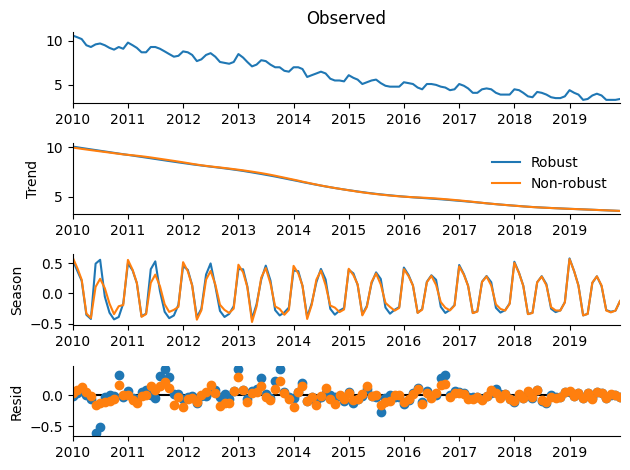

In [25]:
def add_second_stl_to_plot(fig, fitted_stl, labels):
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(fitted_stl, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(labels, frameon=False)
                

stl_robust = STL(df[['unemp_rate']], robust=True).fit()
stl_non_robust = STL(df[['unemp_rate']], robust=False).fit()
fig = stl_robust.plot()
add_second_stl_to_plot(fig, stl_non_robust, ['Robust', 'Non-robust'])
sns.despine()
plt.tight_layout()

Hodrick-Prescott 滤波器——虽然这种方法并不是真正的季节性分解方法，但它是一种数据平滑技术，用于消除与经济周期相关的短期波动。 通过消除这些，我们可以揭示长期趋势。 HP 滤波器常用于宏观经济学。 您可以在 `statsmodels` 的 `hpfilter` 函数中找到它的实现。

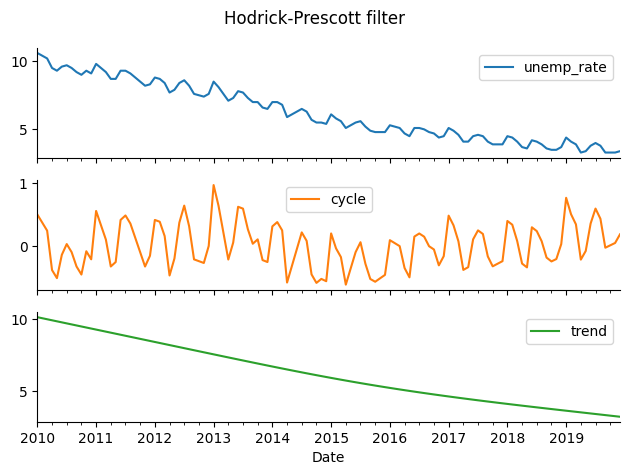

In [27]:
from statsmodels.tsa.filters.hp_filter import hpfilter

hp_df = df[['unemp_rate']].copy()
hp_df['cycle'], hp_df['trend'] = hpfilter(hp_df['unemp_rate'], 129600)
hp_df.plot(subplots=True, title='Hodrick-Prescott filter')

sns.despine()
plt.tight_layout()

## Testing for stationarity in time series

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [35]:
def adf_test(x):
    """_summary_

    Parameters
    ----------
    x : _type_
        _description_
    """
    indices = ['Test Statistics', 'p-value', '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
        
    return results

In [33]:
adf_test(df['unemp_rate'])

Test Statistics            -2.053411
p-value                     0.263656
# of Lags Used             12.000000
# of Observations Used    107.000000
Critical Value (1%)        -3.492996
Critical Value (5%)        -2.888955
Critical Value (10%)       -2.581393
dtype: float64

The null hypothesis of the ADF test states that the time series is not stationary. 

In [ ]:
def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    
    kpss_test = kpss(x, regression=h0_type)
    
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f'Critical value ({key})'] = value
    return results